# Expression Proteomics Course in R
Course: https://cambridgecentreforproteomics.github.io/course_expression_proteomics/

## 0 Imports

In [1]:
if (!require("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager")
}

BiocManager::install(c("QFeatures",
                       "NormalyzerDE",
                       "limma",
                       "factoextra",
                       "org.Hs.eg.db",
                       "clusterProfiler",
                       "enrichplot",
                       "patchwork",
                       "tidyverse",
                       "pheatmap",
                       "ggupset"))

library("QFeatures")
library("NormalyzerDE")
library("limma")
library("factoextra")
library("org.Hs.eg.db")
library("clusterProfiler")
library("enrichplot")
library("patchwork")
library("tidyverse")
library("pheatmap")
library("ggupset")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'QFeatures' 'NormalyzerDE' 'limma' 'factoextra'
  'org.Hs.eg.db' 'clusterProfiler' 'enrichplot' 'patchwork' 'tidyverse'
  'pheatmap' 'ggupset'”
Installation paths not writeable, unable to update packages
  path: /usr/local/lib/R/site-library
  packages:
    b64, git2r, shiny

Loading required package: MultiAssayExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet,

## 1 Use case data

#### Overview
- Know what Gene Ontology terms represent

#### Basics
- Proteomics is very important (for study of proteins)
- Expression proteomics = taking quantitative measurements of protein abundance across different samples
- Bottom up MS = proteins are extracted, offline fractionation for separation. You can then run liquid chromatography and MS/MS, then search against a database then analyse data. Bottom up refers digestion down to a specific peptide (eg. using trypsin makes a trypsin peptide?)
    - MS1: retention time (in LC column), m/z ratio, intensity
        - can have similar sequences with different sequences but same masses (eg. ALRLA vs RLLAA)
    - MS2 (MS/MS): peptide sequence
        - Allows for further breaking of peptide to identify ions, then we can have separated peaks (eg. if we receive ALR and LA, then the sequence would have been ALRLA and not RLLAA)
    - Tandem MS (LC-MS/MS)
    
#### DDA vs DIA
- DDA = Data-dependent acquisition, Top N most abudnat precursor ions selected for fragmentation
    - Data chosen to be fragmented is depednet on that data
    - Variation, not most consistent
    - But most easy to process (why?)
- DIA = Data-indepedent acquisition, All precursor ions in a pre-determined m/z range selected for fragmentation
    - No correlation between two sets of data, indepedent of abduncance
    - More stable, fewer missing values, less bias to abundant peptides
    - Only feasible more recently as more difficult to analyse
        
#### Quantifying peptides via bottom-up MS
- Label-free quantification (MS1)
    - Samples run indepedently on MS
    Ext
- SILAC (Metabolic labelling, MS1)
    - Cells can be grown in media containing heavy vs light AAs
- TMT (Chemical labelling, MS2)
    - Each of the samples will have a specific tag which can be identified in MS2 (as opposed to MS1, indistinguishable at this level since the tags are isobaric so must be released)
    - Isobaric labels covalently attach to K residues
    - HCD fragmentation can release reporter ions of differential mass at MS2 or MS3
    
#### DB search of raw MS data
- From protein sample, run an experimental MS/MS spectrum
- From protein database, perform in silico digestion to form theoretical peptides and perform MS/MS spectrum to achieve theoretical MS/MS spectrum
- Match both spectra to form peptide spectrum mass (PSM)

- Protein inference is complex as a peptide sequence may be shared between multiple proteins. Proteins with shared peptides become protein groups, and a amaster protein is selected to represent each protein group.
- We get a list of PSMs out of a DB search. Recommended aggregate from lowest possible data level ie. PSM or peptide depending on quantification method.

#### Use-case expression proteomics data
- Analysis case study:
    - DDA
    - TMT labelling
    - Analysis from PSM level
    

## 2 Import and Infrastructure

- Bioconductor packages are a set of R packages for reproducible analysis of omics data
    - Summarized Experiment and QFeatures packages will be used
    
- (1) SummaraziedExperiment class, a dedicated DS for MS data
    - 1) Assay slot (quant)
    - 2) rowData (feature)
    - 3) colData (sample info)
- (2) QFeatures class, a list of SEs
    - Allows for data storage across different levels (PSM, peptide, protein)
    - Explicit links maintained between levels
    - Index using R list nomenclature [[]]

In [ ]:
# Load R/Bioconductor libs
library("QFeatures")
library("tidyverse")

# dir for analysis results
dir.create("output", showWarnings = FALSE)

In [ ]:
# import data into QF object
df <- read.delim("data/cell_cycle_total_proteome_analysis_PSMs.txt")
df %>%
    names
cc_qf <- readQFeatures(assayData = df, quantCols = 47:56,  name = "psms_raw")

In [ ]:
cc_qf
cc_qf[[1]] # First summarised experiment in our QFeatures experiment. If [[2]] then we would get an error since we only have 1 el in the data
cc_qf[["psms_raw"]]

In [ ]:
# Quantitation data

assay(cc_qf[[1]]) %>% head()

In [ ]:
## Challenge 1: Accessing information
##
## Explore the QFeatures object you have just created.
## 1. How many sets/SEs do we currently have in the QF object?
## - We have 1 SE (shown from cc_qf)

## 2. How many PSMs have been identified in the data?
## - 45803 PSMs and 10 columns for 10 different tags since it's multiplex

## 3. How do you access and view the quantitation/abundance?
## - Use assay(cc_qf)

In [ ]:
# rowData and colData
cc_qf[["psms_raw"]] %>% 
  rowData()

In [ ]:
## 1. What class is the rowData container? 
##    How many rows and columns are in this data structure?
## - rowData is a df
## - 45803 rows, 54 cols
##
## 2. (i) Extract the rowData and convert it to a tibble or data.frame - as_tibble()
##    (ii) Find a column that contains the peptide sequence. - Sequence
##    (iii) Pull and find how many unique peptide sequences we have - 26738
##
## 3. How many protein groups (master proteins) are there?
## 

In [ ]:
rD <- cc_qf[["psms_raw"]] |> rowData() |> as_tibble()
rD |> dim()
# Goal: find number of unique sequences
rD |> distinct(Sequence) # Gives us a tibble with 26738 rows so we have 26738 unique peptide sequences

In [ ]:
rD |> names()
rD |> count(Number.of.Protein.Groups) # Number of protein groups for *each* PSM. Some PSMs have more than one protein group, which could be why there are multiple master proteins for some entries in the data 
rD |> pull(Master.Protein.Accessions) |> unique() |> as_tibble() |> count() # 5267 unique master proteins

# Most PSMs will be assigned to one protein group. One master protein will be assigned to each protein group as a "representative protein".

In [ ]:
cc_qf[["psms_raw"]] %>% 
    colData() 

metadata_df <- read.csv("data/samples_meta_data.csv", row.names = 1)
metadata_df

#cc_qf[[1]] |> colData() # empty data with 10 rows
colnames(cc_qf[[1]]) <- rownames(metadata_df)

colData(cc_qf) <- metadata_df
colData(cc_qf)
#cc_qf[[1]] |> colData()  # still empty... but we annotated the coldata of the QF object
colData(cc_qf[[1]]) <- colData(cc_qf)
colnames(cc_qf[[1]]) <- cc_qf$sample
colnames(cc_qf[[1]]) 

## Challenge 3: Miscleavages
##
## One of the pieces of information given by the 3rd party
## software used is the number of missed cleavages. This is 
## stored in a rowData column named "Number.of.Missed.Cleavages". 
##
## Can you count how many occurrences of missed cleavages 
## there are in our data?
## 
cc_qf[[1]] |> 
    rowData() |>
    as_tibble() |>
    count(Number.of.Missed.Cleavages) # 9709 = 1, 1106 = 2


## 3 Data Filtering and Cleaning

#### Overview
- Create a copy of raw data
- Basic data cleaning
- Data specific quality control cleaning tailored to data set and experimental design

- Basic data cleaning. Remove: 
    - PSMs w/o protein assignment (protein groups = 0?)
    - PSMS without quantitative data
    - PSMs from contaminant protein
- Is the PSM associated with the correct peptide and protein sequence? Remove:
    - PSMe that are not rank 1
    - PSMs that are not unambiguous
    - PSMs that are not unique
- Data spec filtering
    - TMT data processed with Proteome Discoverer:
    - Co-isolate inteference (%)
    - Reporter ion signal-to-noise ratio
    - Synchronous precursor selection masss matches (SPS-MM%)

In [ ]:
library("QFeatures")
library("tidyverse")

load("preprocessed/lesson02.rda", verbose = TRUE)

raw_data_copy <- cc_qf[[1]]
cc_qf <- addAssay(x = cc_qf, y = raw_data_copy, name = "psms_filtered") # overwriting the previous object in preparation for filtering. Remember that QFs (cc_qf) has many SEs (psms_raw and psms_filtered)
#?addAssay
cc_qf <- cc_qf |> filterFeatures(~ Master.Protein.Accessions != "", i = "psms_filtered")
#?filterFeatures # can filter by annotation or by formula. 



In [ ]:
## ---------------------------------------------------------------------------------------------------------
## Challenge 1 - contaminants
## ---------------------------------------------------------------------------------------------------------

# Use the `filterFeatures` function to filter out common contaminants that have 
# been flagged during the identification search. How many PSMs are left after
# this step?

#rowDataNames(cc_qf)[[1]]

# cc_qf[["psms_filtered"]] %>%  
#   rowData() %>% 
#   as_tibble() %>% 
#   count(Contaminant)

cc_qf <- cc_qf |> filterFeatures(~ Contaminant == "False", "psms_filtered") 
cc_qf
# 3 args: QF, filter function, index in QF. Adding (i =) psms_filtered, means we only filter the second part

In [ ]:
## ---------------------------------------------------------------------------------------------------------
## Challenge 2 - PSM ranking
## ---------------------------------------------------------------------------------------------------------

# Since individual spectra can have multiple candidate PSMs, Proteome Discoverer
# uses a scoring algorithm to determine the probability of a PSM being incorrect.
# Once each candidate PSM has been given a score, the one with the lowest score
# (lowest probability of being incorrect) is allocated rank 1. The PSM with the
# second lowest probability of being incorrect is rank 2, and so on. For the
# analysis, we only want rank 1 PSMs to be retained. The majority of search
# engines, including SequestHT (used in this analysis), also provide their own PSM
# rank. To be conservative and ensure accurate quantitation, we also only retain
# PSMs that have a search engine rank of 1.
# 
# 1. Find the columns `Rank` and `Search.Engine.Rank` in the dataset and tabulate 
# how many PSMs we have at each level
# 
# 2. Use `filterFeatures` and keep,
# * PSMs with a `Rank` of 1
# * PSMs with a `Search.Engine.Rank` of 1
# * High confidence PSMs that have been unambiguously assigned

# 1 - see sequest algo
cc_qf[[2]] |>
    rowData() |>
    as_tibble() |>
    count(Rank) # 42185

cc_qf[[2]] |>
    rowData() |>
    as_tibble() |>
    count(Search.Engine.Rank) # 41794

# 2
cc_qf[[2]] |>
    rowData() |>
    as_tibble() |>
    names()

# cc_qf |> filterFeatures(~Rank == 1 & Search.Engine.Rank == 1 & PSM.Ambiguity == "Unambiguous", "psms_filtered")
                        
cc_qf <- cc_qf |> 
    filterFeatures(~ Rank == 1, "psms_filtered") |> # 42185
    filterFeatures(~ Search.Engine.Rank == 1, "psms_filtered") |> # 41794
    filterFeatures(~ PSM.Ambiguity == "Unambiguous", "psms_filtered") # 41794

In [ ]:
cc_qf <- cc_qf |> filterFeatures(~ Number.of.Protein.Groups == 1, "psms_filtered")
cc_qf # 40044

#### TMT data
Extra considerations for TMT data:
- Average reporter ion S/N ratio
    - Reporter ion measurements derived from a small number of ions so more prone to random effects and reduced accuracy. Nede to remove PSMs with this quantitation.
- Isolation interference 
    - When many TMT-labelled precursor peptides co-isolated within one data acquisition window.
- Synchronous precursor selection mass matches (SPS-MM)
    - Quantifies % of MS3 fragments that can be traced to the precursor peptides

In [ ]:
cc_qf <- cc_qf %>% # The following values are the default quality control thresholds suggested by Thermo Fisher
  filterFeatures(~ Average.Reporter.SN >= 10, 
                 na.rm = TRUE, i = "psms_filtered") %>%
  filterFeatures(~ Isolation.Interference.in.Percent <= 75, 
                 na.rm = TRUE, i = "psms_filtered") %>%
  filterFeatures(~ SPS.Mass.Matches.in.Percent >= 65, 
                 na.rm = TRUE, i = "psms_filtered") 
cc_qf

#### False Discovery Rate
- To identify peptides present, third party software used for DB search by matching raw MS to theoretical spectra of protein database
- FDR = Proportion of false positive identifications in the data
- Each MS spectra can have multiple PSMs, but only some are a correct match between raw and peptide spectra
- Need to control false +ves
- Each PSM is given a score indicating how good the match between experimental and theoretical spectra are, and decoy PSMs will have lower match scores. The formula for the FDR is $${FDR = \frac{2 \times Decoy}{Target + Decoy}}$$
- During DB search, rank 1 PSMs used to calculate FDR. Keeping FDR < 0.01 means that 1% of PSMs are false positives
- Can't filter on PSM FDR as FDR is amplified moving from PSM to peptide to protein since TP PSMs accumulate TP peptides, proteins while FP PSMs are random


In [ ]:
rowData(cc_qf)[[2]] |>
    as_tibble() |> 
    count(Confidence)

protein_data_PD <- read.delim(file = "data/cell_cycle_total_proteome_analysis_Proteins.txt")
#head(protein_data_PD)

psm_data_QF <- cc_qf[[2]] |>
    rowData() |>
    as.data.frame() # just convert to df
# psm_data_QF 

protein_data_PD <- protein_data_PD |>
    select(Accession, Protein.FDR.Confidence.Combined) # only these two rows
# head(protein_data_PD)

fdr_confidence <- left_join(x = psm_data_QF, y = protein_data_PD, by = c("Master.Protein.Accessions" = "Accession")) |>
    pull("Protein.FDR.Confidence.Combined")
# fdr_confidence

rowData(cc_qf[[2]])$Protein.FDR.Confidence <- fdr_confidence

cc_qf[[2]] |>
    rowData() |>
    as_tibble() |>
    pull(Protein.FDR.Confidence) |>
    table()

cc_qf
cc_qf <- cc_qf |>
    filterFeatures(~ Protein.FDR.Confidence == "High", "psms_filtered")

In [ ]:
cc_qf[[2]] |>
    rowData() |>
    as_tibble() |>
    pull(Protein.FDR.Confidence) |>
    table()

#### Cleaning missing data

Why might there be missing data?
- Biological - peptide genuinely absent from sample
- Technical reasons - technical variation and stochastic nature of MS


In [ ]:
nNA(cc_qf, i="psms_filtered")
mv_raw <- nNA(cc_qf, i = "psms_raw")
mv_filtered <- nNA(cc_qf, i = "psms_filtered")

In [ ]:
mv_raw$nNAcols |>
    as_tibble() |>
    mutate(condition = colData(cc_qf)$condition) |>
    ggplot(aes(x = name, y = pNA, group = condition, fill = condition)) +
        geom_bar(stat = "identity") +
        labs(x = "Sample", y= "Proportion of missing values") + 
        theme_bw()

mv_filtered$nNAcols |>
    as_tibble() |>
    mutate(condition = colData(cc_qf)$condition) |>
    ggplot(aes(x = name, y = pNA, group = condition, fill = condition)) +
        geom_bar(stat = "identity") +
        labs(x = "Sample", y= "Proportion of missing values") + 
        theme_bw()

In [ ]:
## ---------------------------------------------------------------------------------------------------------
## Challenge 3 - missing values
## ---------------------------------------------------------------------------------------------------------

# How many PSMs do we have with (i) 0 missing values, (ii) 1 missing value, (iii) 
# 2 or more missing values, across samples, before and after filtering?

mv_raw$nNArows |>
    as_tibble() |>
    count(nNA) # 45263, 224, 316

mv_raw$nNArows |>
    as_tibble() |>
    filter(nNA >= 2) |>
    count()

mv_filtered$nNArows |>
    as_tibble() |>
    count(nNA) # 25687, 11, 1


### Alt solution:

mv_raw$nNArows |>
  as_tibble() |>
  summarise(NA0 = sum(nNA == 0),
        	NA1 = sum(nNA == 1),
        	NA2more = sum(nNA >= 2))

mv_filtered$nNArows |>
  as_tibble() |>
  summarise(NA0 = sum(nNA == 0),
        	NA1 = sum(nNA == 1),
        	NA2more = sum(nNA >= 2))

In [ ]:
#?filterNA
cc_qf <- cc_qf |> filterNA(pNA = 0, i = "psms_filtered")
nNA(cc_qf, i = "psms_filtered")$nNA

## 4 Data transformation aggregation and normalisation

- Aggregation is PSM to proteins (sometimes referred to summarisation)

- PSM raw abundance must be normalised to apply hypothesis. Base 2 is usually used as it makes interpretationa dn visualisation easier - any protein that halves in abudncance will have a 0.5 fold change which is a log2 fold change of -1. 
- Normalisation removes sample to sample variation/ It helps remove/minimise random, irrelevant variation while retaining biologically relevant variation. 
- Many methods exist eg. normalisation based on medians in boxed plots.

- Sources of variability:
    - Biological: differences in samples
    - Technical: Sample preparation
    - Systematic: Bias in processing
    
   
- How is technical variability minimised?
    - Replication (helps us understand the variance)
    - Comparison/control
    - Blocking, removing the contribution ofo nuisance factors
    - Randomisation, avoid adding systematic biases
    
    

In [49]:
library("QFeatures")
library("tidyverse")
load("preprocessed/lesson03.rda", verbose = TRUE)

Loading objects:
  cc_qf


In [ ]:
## Abundance of untransformed data:
# Raw
cc_qf[[2]] |>
    assay() |> # ensures only quantitative data
    longFormat() |> # ggplot needs it in long format
    ggplot(aes(x = value)) + # aes, x = value 
    geom_histogram() +
    xlab("Abundance (raw)")

# Log2
cc_qf[[2]] |>
    assay() |>
    longFormat() |>
    ggplot(aes(x = log2(value))) +
    geom_histogram() +
    xlab("Abundance (Log2)")

In [ ]:
load("preprocessed/lesson03.rda", verbose = TRUE)
cc_qf <- aggregateFeatures(cc_qf,  # psms to peptides 
                            i = "psms_filtered", # (SE) data from cc_qf (QF)
                            fcol = "Sequence", # how do we aggregate?
                            name = "peptides", # new assay name
                            fun = base::colSums, # robust method (NAs excluded before fit)
                            na.rm = TRUE)
                            

cc_qf <- aggregateFeatures(cc_qf, # peptides to proteins
                           i = "peptides",
                           fcol = "Master.Protein.Accessions",
                           name = "proteins",
                           fun = base::colSums,
                           na.rm = TRUE)

cc_qf

In [ ]:
cc_qf[[2]] |> 
    rowData() |>
    as_tibble() |>
    pull(Sequence) |>
    length()

cc_qf[[2]] |> 
    rowData() |>
    as_tibble() |>
    pull(Sequence) |>
    unique() |>
    length()

cc_qf[[2]] |> 
    rowData() |>
    as_tibble() |>
    pull(Master.Protein.Accessions) |>
    unique() |>
    length()

In [ ]:
## ---------------------------------------------------------------------------------------------------------
## Log transformation
## ---------------------------------------------------------------------------------------------------------

cc_qf <- logTransform(object = cc_qf, 
                      base = 2, 
                      i = "proteins", 
                      name = "log_proteins")


cc_qf

## ---------------------------------------------------------------------------------------------------------
## Normalisation
## ---------------------------------------------------------------------------------------------------------

cc_qf <- normalize(cc_qf, 
                   i = "log_proteins", 
                   name = "log_norm_proteins",
                   method = "center.median")

cc_qf

?QFeatures::normalize

In [ ]:
## ---------------------------------------------------------------------------------------------------------
## Challenge 2 
## ---------------------------------------------------------------------------------------------------------

# Create two boxplots pre- and post-normalisation to visualise the effect it has
# had on the data and add colour to distinguish between conditions.


load("preprocessed/lesson03.rda", verbose = TRUE)
cc_qf <- aggregateFeatures(cc_qf,  # psms to peptides 
                            i = "psms_filtered", # (SE) data from cc_qf (QF)
                            fcol = "Sequence", # how do we aggregate?
                            name = "peptides", # new assay name
                            fun = base::colSums, # robust method (NAs excluded before fit)
                            na.rm = TRUE)
                            

cc_qf <- aggregateFeatures(cc_qf, # peptides to proteins
                           i = "peptides",
                           fcol = "Master.Protein.Accessions",
                           name = "proteins",
                           fun = base::colSums,
                           na.rm = TRUE)
cc_qf <- logTransform(object = cc_qf, 
                      base = 2, 
                      i = "proteins", 
                      name = "log_proteins")



cc_qf <- normalize(cc_qf, 
                   i = "log_proteins", 
                   name = "log_norm_proteins",
                   method = "center.median")

cc_qf

plot1 <- cc_qf[[5]] |> 
    assay() |>
    longFormat() |>
    ggplot(aes(y = value, x = colname, fill = colname)) +
    geom_boxplot() + 
    labs(x = "Samples", y = "Abundance (Log2)", title = "Pre-normalisation")

plot2 <- cc_qf[[6]] |> 
    assay() |>
    longFormat() |>
    ggplot(aes(y = value, x = colname, fill = colname)) +
    geom_boxplot() +
    labs(x = "Samples", y = "Abundance (Log2)", title = "Post-normalisation")


require(patchwork)
plot1 + plot2 

# cc_qf[[5]] |> 
#     assay() |>
#     longFormat() |>
#     ggplot(aes(y = value)) +
#     geom_boxplot()


# Solution:
# pre_norm <- cc_qf[["log_proteins"]] %>%
#   assay() %>%
#   longFormat() %>%
#   mutate(Condition = strsplit(as.character(colname), split = "_") %>% 
#            sapply("[[", 1)) %>%
#   ggplot(aes(x = colname, y = value, fill = Condition))  +
#   geom_boxplot() +
#   labs(x = "Sample", y = "log2(abundance)", title = "Pre-normalization") +
#   theme(legend.position = "none")

# post_norm <- cc_qf[["log_norm_proteins"]] %>%
#   assay() %>%
#   longFormat() %>%
#   mutate(Condition = strsplit(as.character(colname), split = "_") %>% 
#            sapply("[[", 1)) %>% 
#   ggplot(aes(x = colname, y = value, fill = Condition))  +
#   geom_boxplot() +
#   labs(x = "Sample", y = "log2(abundance)", title = "Post-normalization") 



In [ ]:
##  Challenge 3: Visualising the impact of data transformation and normalisation
##
## Create three density plots to visualise the distribution of intensities in (1) the raw protein data, (2) the log transformed protein data and (3) the log normalised protein data. 
##
##
par(mfrow = c(1, 3))

cc_qf[[4]] |>
    assay() |> # ensures only quantitative data
    longFormat() |> # ggplot needs it in long format
    ggplot(aes(x = value)) + # aes, x = value 
    geom_density() +
    xlab("Abundance (raw)")

cc_qf[[5]] |>
    assay() |>
    longFormat() |>
    ggplot(aes(x = value)) +
    geom_density() +
    xlab("Abundance (Log2)")

cc_qf[[6]] |>
    assay() |>
    longFormat() |>
    ggplot(aes(x = value)) +
    geom_density() +
    xlab("Abundance (Log2 + Norm)")


# Solution:
# cc_qf[["proteins"]] %>%
#   assay() %>%
#   plotDensities(legend = FALSE, 
#                 main = "Raw proteins") 

# cc_qf[["log_proteins"]] %>%
#   assay() %>%
#   plotDensities(legend = FALSE, 
#                 main = "Log2 proteins") 

# cc_qf[["log_norm_proteins"]] %>%
#   assay() %>%
#   plotDensities(legend = FALSE, 
#                 main = "Log2 norm proteins") 

## 5 Protein Exploration

#### The .n column

- .n column represents different things depending on the object. It represents the number of child features aggregated per parent feature
    - If peptide data, .n = number of PSMs aggregated to form that level of aggregation
    - If protein data, .n = # of peptides per master protein accession
- Subset this information using subsetByFeature() function

#### PCA analysis
- Dimensionality reduction for visualisation
- Shows patterns, clusters, and outliers in high dimensionality space
- PCA looks at all pairwise calculations to calculate a covariance matrix (nxn matrix if n samples). 
    - Covariance = how do the samples vary together (ie relation, correlation)
    - Covariance matrix + eigendecomposition allows for conversion to eigenvalues and eigenvectors
    - 


In [ ]:
library("QFeatures")
library("tidyverse")
library("factoextra")
load("preprocessed/lesson04.rda", verbose = TRUE)

In [ ]:
## Part 1 - assay links
## ---------------------------------------------------------------------------------------------------------
## Add explicit link between final protein data "log_norm_proteins"
## and raw PSM data "psms_raw", using "Master.Protein.Accessions"
## ---------------------------------------------------------------------------------------------------------
load("preprocessed/lesson04.rda", verbose = TRUE)

plot(cc_qf)
cc_qf <- addAssayLink(object = cc_qf,
                      from = "psms_raw",
                      to = "psms_filtered")
plot(cc_qf) 
cc_qf
# A copy of psms_raw was created to form psms_filtered which was added back into QF using addAssay, and this doesn't maintain a link.
# Adding a relation between raw and filtered ensures traceability


In [ ]:
cc_qf[[6]] |> nrow() # 3823 master proteins

In [ ]:
## ---------------------------------------------------------------------------------------------------------
## Challenge 1: Final PSM, peptide and protein count
## ---------------------------------------------------------------------------------------------------------

# Determine how many PSMs, peptides and proteins were lost 
# during processing of the raw data to our final list?

# Hint: 
# (i) start with calculating the number of PSMs, peptides 
# and proteins we have in "psms_raw". 
# (ii) Then examine the data level called "psms_filtered".

# e.g. to count peptides in "psms_raw"....

## PSMs ...
psms_start <- cc_qf[[1]] |> nrow()
psms_final <- cc_qf[[2]] |> nrow()

psms_lost <- psms_start - psms_final
message("psms lost = ", psms_lost)

## peptides ...
peptides_start <- cc_qf[[1]] |> 
                    rowData() |>
                    as_tibble() |>
                    pull(Sequence) |>
                    unique() |>
                    length()
peptides_final <- cc_qf[[3]] |> nrow()
peptides_lost <- peptides_start - peptides_final
message("peptides lost = ", peptides_lost)
## proteins

proteins_start <- cc_qf[[1]] |>
                    rowData() |>
                    as_tibble() |>
                    pull(Master.Protein.Accessions) |> 
                    unique() |>
                    length()

proteins_end <- cc_qf[[4]] |> nrow()
proteins_lost <- proteins_start - proteins_end
message("proteins lost = ", proteins_lost)

In [ ]:
cc_qf[[1]] |> rowData()

In [ ]:
cc_qf[[3]] |> rowData() |> names()
# The .n column is present here but not at the psms level assays, added by aggregateFeatures func

n_data <- cc_qf[[6]] |> 
    rowData() |>
    as_tibble() |>
    pull(.n) |>
    table() 

# ie. 1228 with 1 peptide, 710 with 2 peptides....

In [ ]:
## ---------------------------------------------------------------------------------------------------------
## Challenge 2: Examining peptide support
## ---------------------------------------------------------------------------------------------------------

# (i)  Using the information we have in the .n column create a 
#      graph to visualise peptide support.



# (ii) What is,
#   - the maximum number of peptides we have available for 
#     one given protein?
#   - the most common number of peptides available for any
#     given protein?
#   - the median number of peptides available for any 
#     given protein?

# (i)
cc_qf[[6]] |>
    rowData() |>
    as_tibble() |>
    ggplot(aes(x = .n)) +
    geom_histogram(binwidth = 1)


# solution:
# peptide_df <- cc_qf[[6]] |>
#     rowData() |>
#     as_tibble() |>
#     select(.n) |>
#     mutate(peptide_n = ifelse(.n<=7, .n, "8+")) |>
#     count(peptide_n)

# ggplot(peptide_df, aes(x = peptide_n, xend = peptide_n, y = 0, yend = n)) +
#     geom_segment() 

# (ii) 
cc_qf[[6]] |>
    rowData() |>
    as_tibble() |>
    pull(.n)|>
    summary() 

s <- cc_qf[[6]] |>
    rowData() |>
    as_tibble() |>
    pull(.n) |>
    table() |>
    sort(decreasing = TRUE)

s[1] # mode

# 223 is the max number of peptides
# 1 is the most common number of peptides available (by inspection, how do i do it by function?)
# 2 is the median number of peptides

In [ ]:
O43583 <- subsetByFeature(cc_qf, "O43583")
experiments(O43583) # you can see that it's supported by 4 peptides from 5 PSMs



In [ ]:
O43583[, , c("psms_filtered", "peptides", "proteins")] %>% # multi-dimensional subsetting
  longForm() %>% # so suitable for ggplot
  as_tibble() %>%
  mutate(assay_order = factor(assay, # new column called assay_order
                              levels = c("psms_filtered", 
                                         "peptides", 
                                         "proteins"))) %>%
  ggplot(aes(x = colname, y = log2(value), colour = assay)) + 
  geom_point() +
  geom_line(aes(group = rowname)) + # 10 row names
  theme(axis.text.x = element_text(angle = 45, size = 7)) + # rotates and makes x labels smaller
  facet_wrap(~ assay_order) # separates into different assays graphs)

# Other useful functions that we do not have time to cover today include subsetByAssay, subsetByColData, subsetByColumn, subsetByFilter, subsetByRow, subsetByOverlap

PCA in several parts
- Scaling and centering the data (mean = 0, sd = 1)
- Generation of covariance matrix of dimensions pxp where p = # of dimensions
- Eigendecomposition to calc evals and evecs


In [ ]:
protein_pca <-
    cc_qf[[6]] |> 
    filterNA() |>
    assay() |> # numerical data
    t() |> # transposition
    prcomp(scale = TRUE, center = TRUE)

#protein_pca
#class(protein_pca)
str(protein_pca)

## scree plot
fviz_screeplot(protein_pca)
protein_pca$x |>
    as_tibble() |>
    mutate(condition = cc_qf[[6]]$condition) |> # 
    ggplot(aes(x = PC1, y = PC2, colour = condition)) + 
    geom_point(size = 4) +
    theme_bw() # this shows us how clusters are formed by condition

## 6 Statistical Analysis

#### Overview
- Defining and applying linear model for stats testsing
- Limma and sharing of info between proteins
- Model diagnositics
- Interpreting output of model


#### Linear model assumptions
Explanatory variables (features, conditions)
- Linearity = linear relationship between conditions and abundance
- No multicollinearity = not correlated
Error terms (residueals)
- Homoscedasticity = Equal variance
- No autocorrelation = Errors are indepdendent
- Gaussian distribution = holds true if log transformed

#### Linear modelling of protein abundances

H0 = no difference between means
H1 = difference

```R
# lm = linear model function:
lm(formula = x ~ y)Overview
```
- Intercept term computes the mean
- Condition treatment intercept is the difference between mean of condition treatment and controls.

#### `Limma` - sharing information between proteins
- High throughput experiments are often lowly replicated
- n = 3 is common in proteomics, so estimates of variance are likely to be inaccurate
- Underestimation = false positives (FP), overestimation = false negatives (FN)
- Assuming variance s similar between all proteins, we can "moderate" observed errors in the linear model towards more likely value 
    - Reduces FP and FN
- To check if something is wrong, you can plot the p-value histogram. No difference = H0 is true and p-value is uniformly distributed. For proteins with change in abundance, low p-values would be expected. (was something wrong with the anti-conservative

In [32]:
## ---------------------------------------------------------------------------------------------------------
## Load R/Bioconductor libraries
## ---------------------------------------------------------------------------------------------------------
library("QFeatures")
library("tidyverse")
library("pheatmap")
library("limma")


## ---------------------------------------------------------------------------------------------------------
## Loading data from lesson 4
## ---------------------------------------------------------------------------------------------------------

load("preprocessed/lesson04.rda", verbose = TRUE)


## ---------------------------------------------------------------------------------------------------------
## Extracting the data
## ---------------------------------------------------------------------------------------------------------

## Extract protein list from our QFeatures object - remove sample 1 
all_proteins <- cc_qf[["log_norm_proteins"]]
all_proteins <- all_proteins[, all_proteins$condition %in% c("M", "G1")]

## Ensure that conditions are stored as levels of a factor 
## Explicitly define level order by cell cycle stage
all_proteins$condition <- factor(all_proteins$condition, # in condition, M and G1 are stored as character variables
                                 levels = c("M", "G1")) # M associated with first level, G1 to second level to make them semi-quantitative so math models can think about them as numebres
all_proteins$condition |> levels()

condition <- all_proteins$condition
m_design <- model.matrix(~condition) #~ is formula object 

Loading objects:
  cc_qf


[1] "M"  "G1"

In [33]:
## ---------------------------------------------------------------------------------------------------------
## Limma: setting up a design matrix
## ---------------------------------------------------------------------------------------------------------

## Design a matrix containing all factors that we wish to model
condition <- all_proteins$condition

m_design <- model.matrix(~ condition)
m_design

m_design_without_intercept <- model.matrix(~ 0 + condition)
m_design_without_intercept # now 4-6 is modelling mean instead of difference (slope of lm)

,(Intercept),conditionG1
1,1,0
2,1,0
3,1,0
4,1,1
5,1,1
6,1,1


,conditionM,conditionG1
1,1,0
2,1,0
3,1,0
4,0,1
5,0,1
6,0,1


In [34]:
## ---------------------------------------------------------------------------------------------------------
## Limma: fitting a linear model
## ---------------------------------------------------------------------------------------------------------

## Fit linear model using the design matrix 
fit_model <- lmFit(object = assay(all_proteins), design = m_design) # object cant be qfeatures directly so must be quant data (ie. call assay)
fit_model



An object of class "MArrayLM"
$coefficients
           (Intercept) conditionG1
A0A0B4J2D5  -0.7531231 -0.34555548
A0A2R8Y4L2  -1.4766536 -0.16417717
A0AVT1       2.3474237  0.14499265
A0MZ66      -0.1095379 -0.09233573
A1L0T0      -2.8575218 -0.29179623
3818 more rows ...

$rank
[1] 2

$assign
[1] 0 1

$qr
$qr
  (Intercept) conditionG1
1  -2.4494897  -1.2247449
2   0.4082483   1.2247449
3   0.4082483   0.2898979
4   0.4082483  -0.5265986
5   0.4082483  -0.5265986
6   0.4082483  -0.5265986
attr(,"assign")
[1] 0 1
attr(,"contrasts")
attr(,"contrasts")$condition
[1] "contr.treatment"


$qraux
[1] 1.408248 1.289898

$pivot
[1] 1 2

$tol
[1] 1e-07

$rank
[1] 2


$df.residual
[1] 4 4 4 4 4
3818 more elements ...

$sigma
A0A0B4J2D5 A0A2R8Y4L2     A0AVT1     A0MZ66     A1L0T0 
0.19714619 0.16505173 0.07564640 0.07255657 0.29598036 
3818 more elements ...

$cov.coefficients
            (Intercept) conditionG1
(Intercept)   0.3333333  -0.3333333
conditionG1  -0.3333333   0.6666667

$stdev.unscal

In [35]:
## ---------------------------------------------------------------------------------------------------------
## Limma: updating using eBayes
## ---------------------------------------------------------------------------------------------------------

final_model <- eBayes(fit = fit_model, # empirical Bayes, adds some stats info
                      trend = TRUE, # abundance correlates with accuracy
                      robust = TRUE) # remove extreme outliers

final_model

An object of class "MArrayLM"
$coefficients
           (Intercept) conditionG1
A0A0B4J2D5  -0.7531231 -0.34555548
A0A2R8Y4L2  -1.4766536 -0.16417717
A0AVT1       2.3474237  0.14499265
A0MZ66      -0.1095379 -0.09233573
A1L0T0      -2.8575218 -0.29179623
3818 more rows ...

$rank
[1] 2

$assign
[1] 0 1

$qr
$qr
  (Intercept) conditionG1
1  -2.4494897  -1.2247449
2   0.4082483   1.2247449
3   0.4082483   0.2898979
4   0.4082483  -0.5265986
5   0.4082483  -0.5265986
6   0.4082483  -0.5265986
attr(,"assign")
[1] 0 1
attr(,"contrasts")
attr(,"contrasts")$condition
[1] "contr.treatment"


$qraux
[1] 1.408248 1.289898

$pivot
[1] 1 2

$tol
[1] 1e-07

$rank
[1] 2


$df.residual
[1] 4 4 4 4 4
3818 more elements ...

$sigma
A0A0B4J2D5 A0A2R8Y4L2     A0AVT1     A0MZ66     A1L0T0 
0.19714619 0.16505173 0.07564640 0.07255657 0.29598036 
3818 more elements ...

$cov.coefficients
            (Intercept) conditionG1
(Intercept)   0.3333333  -0.3333333
conditionG1  -0.3333333   0.6666667

$stdev.unscal

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


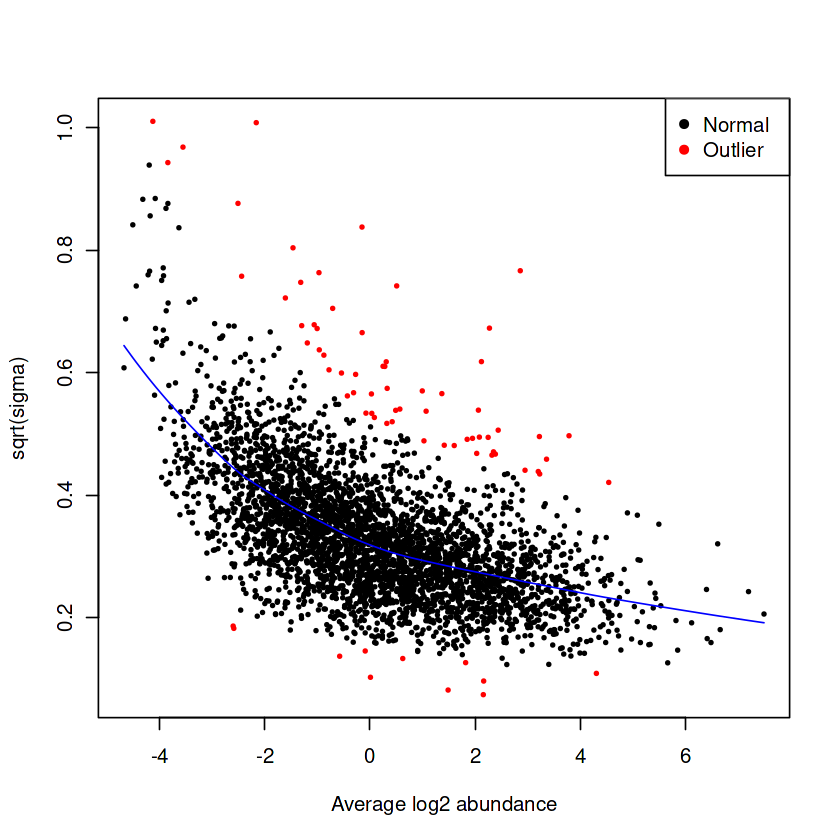

,Protein,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Q9NQW6,-2.077921,2.641270,-40.40812,1.139582e-15,4.356623e-12,25.79468
2,Q9BW19,-2.343592,1.430210,-36.79774,4.073530e-15,7.786553e-12,24.71272
3,P49454,-1.991326,2.598481,-34.88623,8.411188e-15,9.266757e-12,24.07905
4,Q9ULW0,-2.152503,2.476087,-34.52309,9.695796e-15,9.266757e-12,23.95341
5,Q562F6,-3.205603,-1.304111,-32.91865,1.849860e-14,1.414403e-11,23.37677
6,O14965,-2.098029,0.797902,-31.22180,3.791132e-14,2.415583e-11,22.72604


,Protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,direction,significance
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,Q9NQW6,-2.077921,2.641270,-40.40812,1.139582e-15,4.356623e-12,25.79468,down,sig
2,Q9BW19,-2.343592,1.430210,-36.79774,4.073530e-15,7.786553e-12,24.71272,down,sig
3,P49454,-1.991326,2.598481,-34.88623,8.411188e-15,9.266757e-12,24.07905,down,sig
4,Q9ULW0,-2.152503,2.476087,-34.52309,9.695796e-15,9.266757e-12,23.95341,down,sig
5,Q562F6,-3.205603,-1.304111,-32.91865,1.849860e-14,1.414403e-11,23.37677,down,sig
6,O14965,-2.098029,0.797902,-31.22180,3.791132e-14,2.415583e-11,22.72604,down,sig


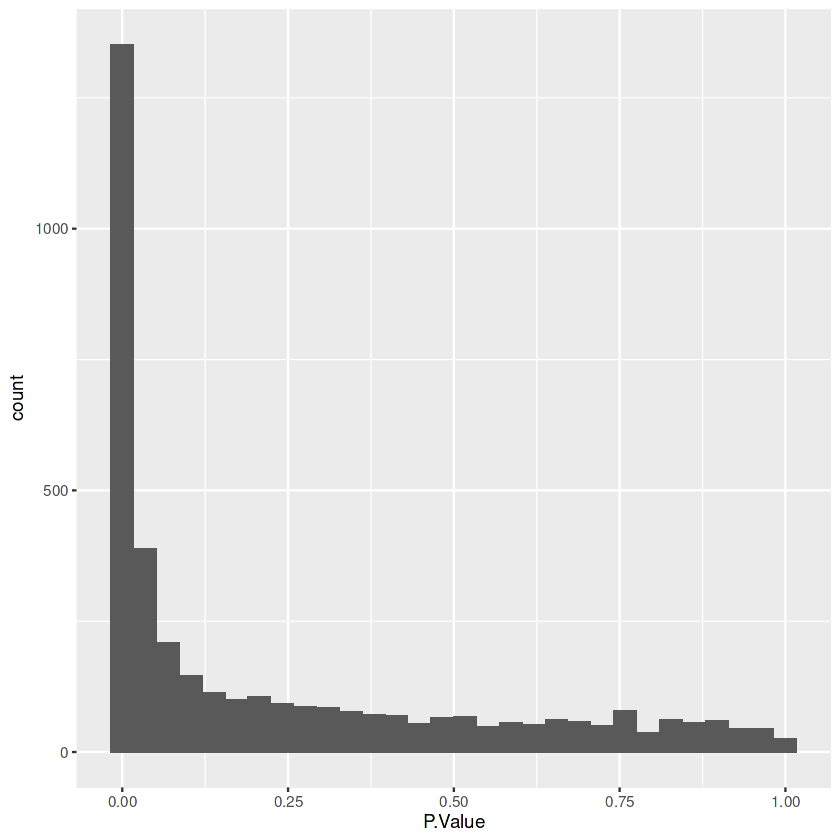

In [43]:
## ---------------------------------------------------------------------------------------------------------
## Limma: accessing the results
## ---------------------------------------------------------------------------------------------------------

# Using topTable to extracts the top-ranked proteins from model
# Note coef = NULL and ANOVA performed

limma_results <- topTable(fit = final_model,   
                          coef = "conditionG1", 
                          adjust.method = "BH",    # Method for multiple hypothesis testing
                          number = Inf) %>%        # Print results for all proteins
  rownames_to_column("Protein") 



## Plot a SA plot to display the residual SD (sigma) versus log abundance 
## for each protein to which our model was  fitted
plotSA(fit = final_model,
       cex = 0.5,
       xlab = "Average log2 abundance")


## Plot a histogram of the raw p-values (not BH-adjusted p-values).
limma_results %>%
  as_tibble() %>%
  ggplot(aes(x = P.Value)) + 
  geom_histogram()


## ---------------------------------------------------------------------------------------------------------
## Limma: Interpreting the results 
## ---------------------------------------------------------------------------------------------------------

## Take a look at the results of our tests
limma_results %>% head()

## ---------------------------------------------------------------------------------------------------------
## Adding significance thresholds
## ---------------------------------------------------------------------------------------------------------

## Define significance based on an adj.P.Val < 0.01.
limma_results <- 
  limma_results %>%
  mutate(direction = ifelse(logFC > 0, "up", "down"), # up/down regulated or in/decrease abundance
         significance = ifelse(adj.P.Val < 0.01, "sig", "not.sig")) # just to show which vals are sig/not significant

head(limma_results)

# We used the test to ask "Does theis protein show significant change in abundance between M and G1 cell cycle changes?"
# H0 = change is 0
# H1 = change > 0
# from output of head(limma_results), we know that the adjusted p-values have significantly different abundances across the stages


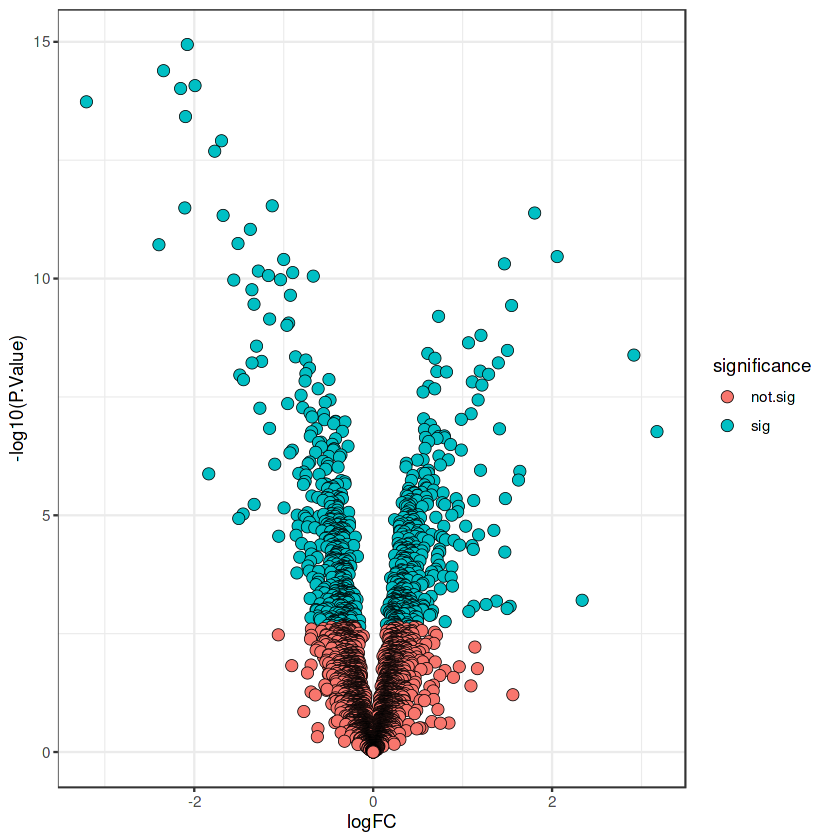

In [44]:
limma_results |> # the boundary is at 2.5 and not 2 since y is -log10(P.Value) while significance was defined with adj.P.val
    ggplot(aes(x = logFC, y = -log10(P.Value), fill = significance)) + 
    geom_point(shape = 21, stroke = 0.25, size = 3) +
    theme_bw()

In [ ]:
limma_results

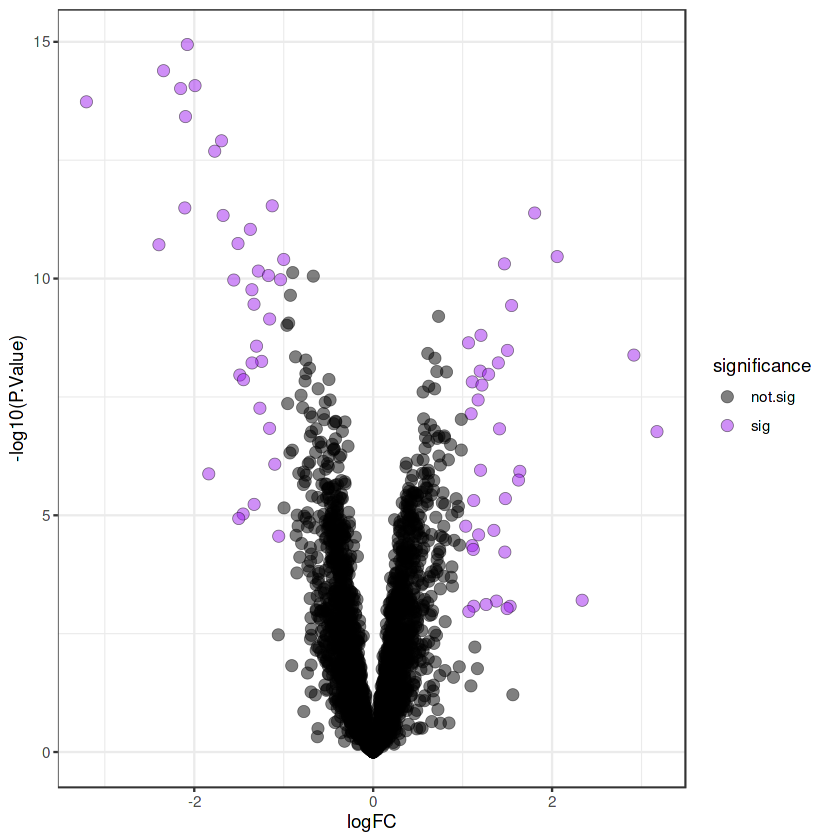

In [55]:

## ---------------------------------------------------------------------------------------------------------
## Challenge - Volcano plots: playing with thresholds
## ---------------------------------------------------------------------------------------------------------

# Re-generate your volcano plot defining significance based on an adjusted 
# P-value < 0.05 and a log2 fold-change of > 1.
chal_results <- limma_results |>
    mutate(significance = ifelse(adj.P.Val < 0.01 & abs(logFC) > 1, "sig", "not.sig")) # perfect :)
# adjusted p values tend not to be plotted since they are a property of the whole set of points
# for raw points, the p-value is independent on that point

chal_results |> 
    ggplot(aes(x = logFC, y = -log10(P.Value), fill = significance)) +
    geom_point(shape = 21, stroke = 0.25, size = 3, alpha = 0.5) +
    theme_bw() +
    scale_fill_manual(values = c("black", "purple"))

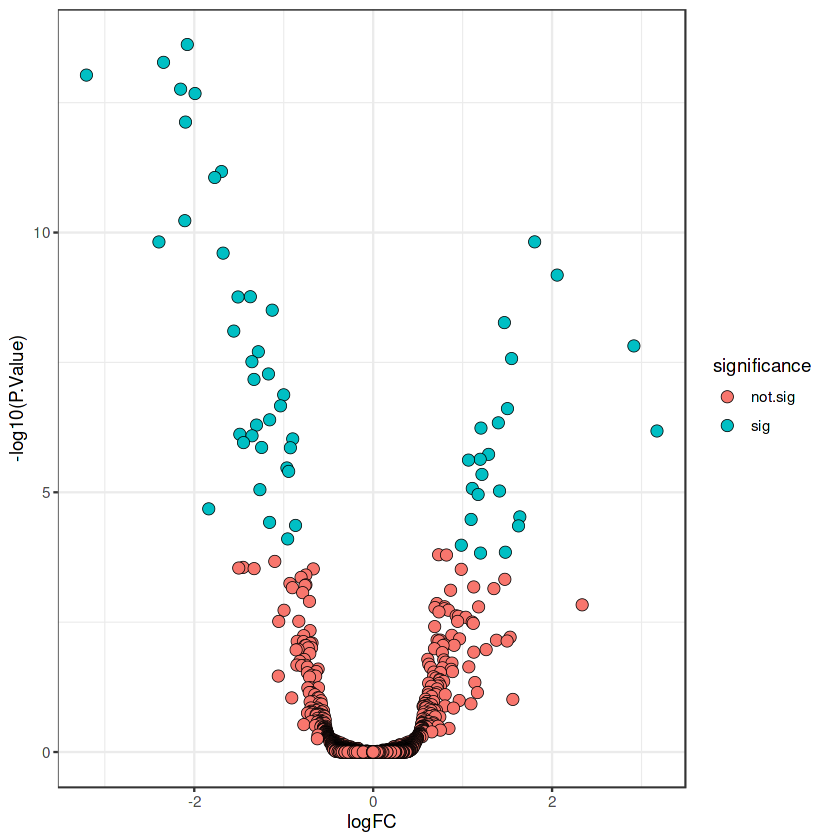

In [75]:
## --------------------------------------------------------------------------------------------------------
## Fold-change thresholds 
## --------------------------------------------------------------------------------------------------------

## choosing a FC threshold ignores the fact we did a test.
## FC can be included by treat()

## Use treat to specify fold change threshold for statistical testing
final_model_treat <- treat(final_model, 
                           lfc = 0.5,
                           trend = TRUE, 
                           robust = TRUE)

limma_results_treat <- topTreat(final_model_treat, 
                                coef = "conditionG1",
                                n = Inf) %>%
  rownames_to_column("Protein")

## Add direction and significance information
limma_results_treat <- limma_results_treat %>%
  mutate(direction = ifelse(logFC > 0, "up", "down"),
         significance = ifelse(adj.P.Val < 0.01, "sig", "not.sig"))

limma_results_treat %>%
  ggplot(aes(x = logFC, y = -log10(P.Value), fill = significance)) +
  geom_point(shape = 21, stroke = 0.25, size = 3) +
  theme_bw()

In [ ]:
## ---------------------------------------------------------------------------------------------------------
## Challenge - Compare logFC thresholding post-hoc with LogFC null hypothesis
## ---------------------------------------------------------------------------------------------------------

# - Compare the overall results for each logFC thresholding approach by creating a 2 x 2 table
# with the number of proteins with increased/decreased abundance and significant/not significant change,
# for each approach.
# - Identify the proteins which are significant when thresholding on the logFC post-hoc, 
# but not when using the TREAT functions to define a logFC threshold for the null hypothesis. 
# - Re-make the volcano plots for the two logFC thresholding approaches, but this time with the proteins
# identified above highlighted by the point shape.

# (i)
limma_results |> 
    as_tibble() |>
    select(c("direction", "significance")) |> 
    table()

limma_results_treat |> 
    as_tibble() |>
    select(c("direction", "significance")) |> 
    table()

# (ii)
sig_logFC <- limma_results |> 
    as_tibble() |>
    filter(significance == "sig") |>
    select(Protein)

sig_logFC_treat <- limma_results_treat |> 
    as_tibble() |>
    filter(significance == "sig") |>
    select(Protein)

protein_list <- anti_join(sig_logFC, sig_logFC_treat)
protein_list

# (iii)
### not finished, see answers. maybe %in% protein_list?


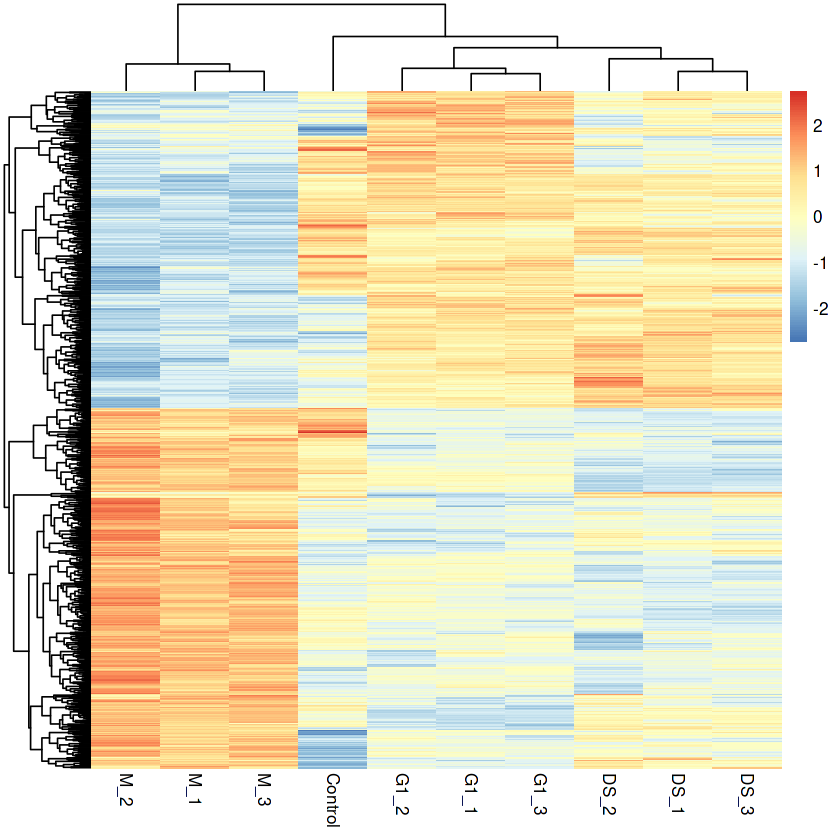

In [91]:
### --------------------------------------------------------------------------------------------------------
## Visualisation - heatmaps
## --------------------------------------------------------------------------------------------------------

## Extract significantly changing proteins
sig_proteins <- limma_results %>%
  filter(significance == "sig") %>%
  pull(Protein)

#sig_proteins

## Extract quant data for the significant proteins
quant_data <- cc_qf[["log_norm_proteins"]] 
quant_data <- quant_data[sig_proteins, ] %>% assay() #creates a qf object only with significant proteins in it
# assay required for numerical values only

#quant_data

## Plot heatmap
pheatmap(mat = quant_data, 
         scale = "row",# normalises across the proteins so you can see up or down for each individual protein
         show_rownames = FALSE)


#### Key Points

- The limma package provides a statistical pipeline for the analysis of differential expression (abundance) experiments
- Empirical Bayes moderation involves borrowing information across proteins to squeeze the per-protein variance estimates towards an expected value based on the behavior of other proteins with similar abundances. This method increases the statistical power and reduces the number of false positives.
- Since proteomics data typically shows an intensity-dependent trend, it is recommended to apply empirical Bayes moderation with trend = TRUE and robust = TRUE. The validity of this approach can be assessed by plotting an SA plot.
- Significance thresholds are somewhat arbitrary and must be selected by the user. However, correction must be carried out for multiple hypothesis testing so significance thresholds should be based on adjusted p-values rather than raw p-values.
- The statistically appropriate way to threshold based on a log fold-change is to use the TREAT functions in limma and define a null hypothesis that the change is below a given value.
- The results of differential expression and abundance analyses are often summarised with volcano plots and heatmaps.



## 7 Gene Ontology enrichment analysis


#### Functional enrichment analysis
- Motivation: what do these proteins do
- Aim: identify functionalities observed more than expected by chance (H0)
- Gene set = set of genes with same function
- Approaches
    - Overrepresentationa analysis (gene set is overrepresented)
    - others like Pathway Topology based methods

    
- H0: no association between differential expression and membership in Gi

- ORA: foreground + background
    - foreground = proteins passing threshold
    - background = proteins could have passed threshold
    

In [50]:
## ---------------------------------------------------------------------------------------------------------
## Load R/Bioconductor libraries
## ---------------------------------------------------------------------------------------------------------
library("QFeatures")
library("patchwork")
library("tidyverse")
library("org.Hs.eg.db")
library("clusterProfiler")
library("enrichplot")
library("pheatmap")


## ---------------------------------------------------------------------------------------------------------
## Loading data from lesson 4, 5, 6
## ---------------------------------------------------------------------------------------------------------

load("preprocessed/lesson04.rda", verbose = TRUE)
load("preprocessed/lesson06.rda", verbose = TRUE)



Loading objects:
  cc_qf
Loading objects:
  limma_results
  all_proteins


In [6]:
## ---------------------------------------------------------------------------------------------------------
## Adding metadata to our results using dplyr 
## ---------------------------------------------------------------------------------------------------------

## Add master protein descriptions to our data
protein_info <- all_proteins %>%
  rowData() %>%
  as_tibble() %>%
  select(Protein = Master.Protein.Accessions, 
         Protein_description = Master.Protein.Descriptions)

## Protein info
protein_info %>% head()

## Add to our data using left.join
limma_results <- limma_results %>% 
  left_join(protein_info, by = "Protein")

sig_changing <- limma_results %>% 
  as_tibble() %>%
  filter(significance == "sig") # only proteins with significance but no directionality (added later)

sig_up <- sig_changing %>%
  filter(direction == "up")

sig_down <- sig_changing %>%
  filter(direction == "down")

sig_up |> 
    pull(Protein_description) |>
    head() 

Protein,Protein_description
<chr>,<chr>
A0A0B4J2D5,"Putative glutamine amidotransferase-like class 1 domain-containing protein 3B, mitochondrial OS=Homo sapiens OX=9606 GN=GATD3B PE=5 SV=1"
A0A2R8Y4L2,Heterogeneous nuclear ribonucleoprotein A1-like 3 OS=Homo sapiens OX=9606 GN=HNRNPA1L3 PE=4 SV=1
A0AVT1,Ubiquitin-like modifier-activating enzyme 6 OS=Homo sapiens OX=9606 GN=UBA6 PE=1 SV=1
A0MZ66,Shootin-1 OS=Homo sapiens OX=9606 GN=SHTN1 PE=1 SV=4
A1L0T0,2-hydroxyacyl-CoA lyase 2 OS=Homo sapiens OX=9606 GN=ILVBL PE=1 SV=2
A1X283,SH3 and PX domain-containing protein 2B OS=Homo sapiens OX=9606 GN=SH3PXD2B PE=1 SV=3


[1] "Golgi reassembly-stacking protein 2 OS=Homo sapiens OX=9606 GN=GORASP2 PE=1 SV=3"
[2] "Selenoprotein S OS=Homo sapiens OX=9606 GN=SELENOS PE=1 SV=3"                    
[3] "Anamorsin OS=Homo sapiens OX=9606 GN=CIAPIN1 PE=1 SV=2"                          
[4] "Krueppel-like factor 16 OS=Homo sapiens OX=9606 GN=KLF16 PE=1 SV=1"              
[5] "Histone H1.10 OS=Homo sapiens OX=9606 GN=H1-10 PE=1 SV=1"                        
[6] "Importin subunit alpha-4 OS=Homo sapiens OX=9606 GN=KPNA3 PE=1 SV=2"

In [17]:
## ---------------------------------------------------------------------------------------------------------
## GO analysis with enrichGO
## ---------------------------------------------------------------------------------------------------------

# enrichGO package for formal analysis to query DBs using data generated with values we give it

## Perform analysis
ego_down <- enrichGO(gene = sig_down$Protein,               # list of down proteins (filtered on proteins)
                     universe = limma_results$Protein,      # all proteins (checks if significant in DB)
                     OrgDb = org.Hs.eg.db,                  # database to query (human)
                     keyType = "UNIPROT",                   # protein ID encoding (it was proteomics)
                     pvalueCutoff = 0.05, 
                     qvalueCutoff = 0.05, 
                     ont = "BP",  #?
                     readable = TRUE)



In [18]:
ego_down$Description |> head(10) # top 10 descriptions for biological processes in downregulated proteins in dataset

[1] "extracellular matrix organization"            
 [2] "extracellular structure organization"         
 [3] "external encapsulating structure organization"
 [4] "transmembrane transport"                      
 [5] "cellular respiration"                         
 [6] "collagen fibril organization"                 
 [7] "cell adhesion"                                
 [8] "mitochondrial transmembrane transport"        
 [9] "cell division"                                
[10] "aerobic respiration"

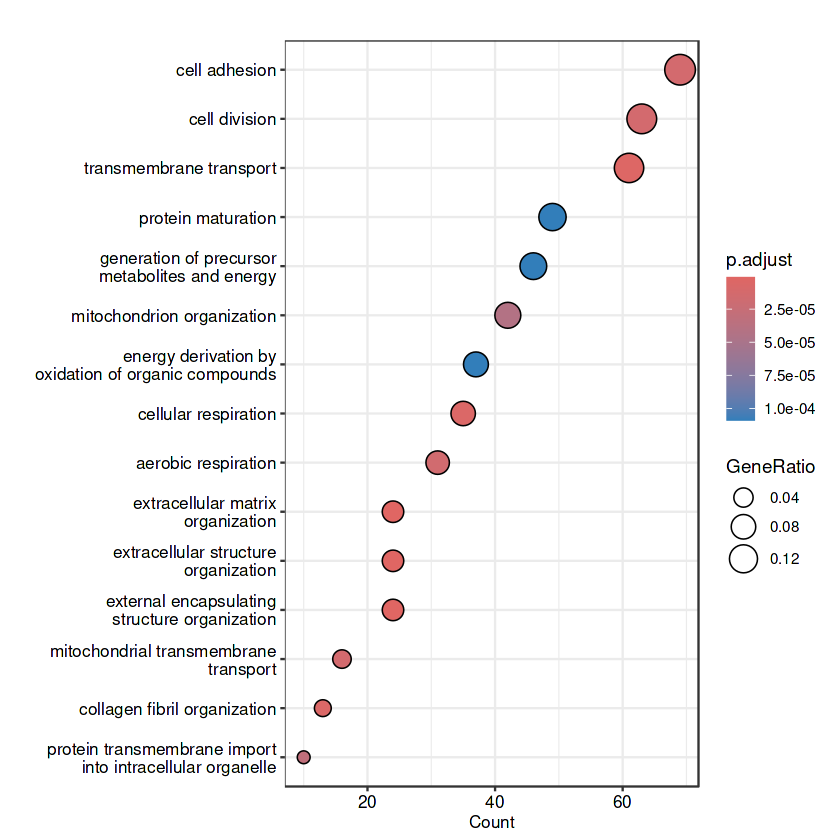

In [19]:
p <- dotplot(ego_down,
             x = "Count",
             showCategory = 15,
             font.size = 10,
             color = "p.adjust")
p

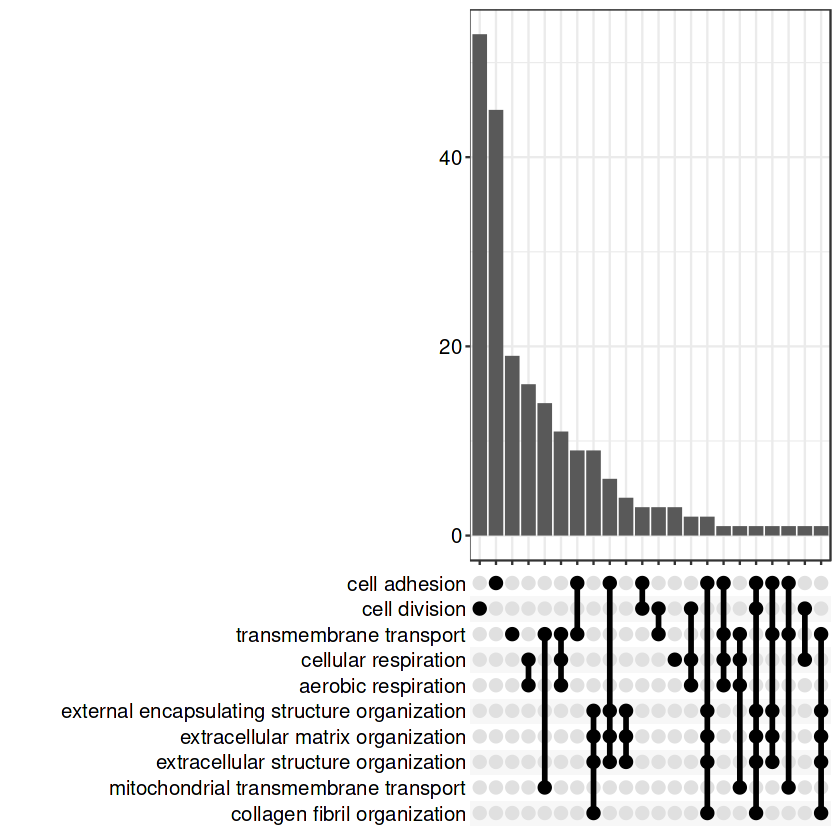

In [20]:
upsetplot(ego_down, n = 10)

[1] "Q9BW19" "P49454" "Q9ULW0" "Q562F6" "O14965" "Q02224" "Q99661" "P52732"
 [9] "O43663" "P48729" "O95067" "Q9BSJ6" "Q14008" "Q9H4H8" "Q69YQ0" "Q16763"
[17] "Q96EA4" "Q9Y6A5" "P30305" "O95997" "Q69YH5" "P52926" "Q8NG31" "O95347"
[25] "O60566" "Q99618" "O75410" "Q9NWV8" "Q13042" "Q96Q89" "Q93008" "P23396"
[33] "Q9NTJ3" "P49916" "P11802" "P06493" "P56211" "Q9BZD4" "Q7RTP6" "O14777"
[41] "Q15691" "O43491" "Q14980" "Q2NKX8" "P11234" "Q9Y266" "O43768" "Q9BPX3"
[49] "P63279" "Q12834" "P53990" "Q6PGN9" "Q9HD42" "P04899" "O00762" "Q96BM9"

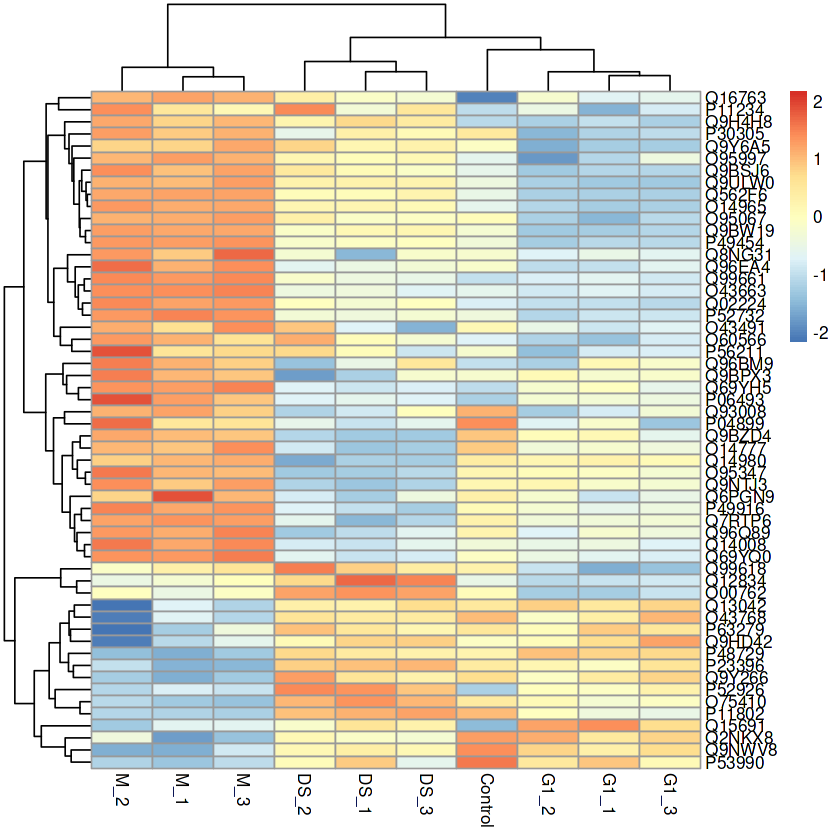

In [48]:
# Challenge: Plot a heatmap for signifcant cell division proteins
# cell division is GO:0051301 (google search)

cell_div_proteins <- p2go |>
    filter(go_id == "GO:0051301") |> # see below for go_id from code without google search
    pull(uniprot_id)

quant_data <- cc_qf[[6]] |> assay()
index <- intersect(sig_changing$Protein, cell_div_proteins) # cell div includes proteins which are downregulated
index
quant_data_cd <- quant_data[index, ] # matrix subset notation is matrix[filter by rows, filter by cols]


pheatmap(mat = quant_data_cd,
          scale = "row",
          show_rownames = TRUE)


#solution: 

# ## Get the GO ID for 'cell division'
# cell_division_go <- ego_down@result %>%
#   filter(Description=='cell division') %>%
#   rownames()

# ## Get the Uniprot IDs for cell division annotated proteins
# cell_division_uniprot_ids <- p2go %>%
#   filter(go_id==cell_division_go) %>%
#   pull(uniprot_id) %>%
#   unique()

# ## Extract quant data
# quant_data <- cc_qf[["log_norm_proteins"]] %>% assay()

# ## Plot heatmap
# pheatmap(mat = quant_data, 
#          scale = "row",
#          show_rownames = FALSE)
# ## Extract quant data for the significant proteins
# quant_data_cd <- quant_data[intersect(sig_changing$Protein, cell_division_uniprot_ids), ]

# ## Plot heatmap
# pheatmap(mat = quant_data_cd, 
#          scale = "row",
#          show_rownames = TRUE)

# cell_division_go
# cell_division_uniprot_ids
# cell_div_proteins